# House price analysis

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Accessing data

In [2]:
dir_grl = '/workspaces/accesibilidad-urbana/data/processed/costo-vivienda/'

In [3]:
years = [2019,2020,2021]
sheet = 'Renta'
tipo = 'rent'
gdf = gpd.GeoDataFrame()

for year in years:
    gdf_tmp = gpd.read_file(dir_grl+f'{year}_{sheet}_PrecioVivienda_AMG_OC22_GCS_v1.geojson',
          driver='GeoJSON')
    
    gdf_tmp['year'] = year
    
    gdf = pd.concat([gdf, gdf_tmp], ignore_index = True, axis = 0)
    
print(gdf.shape)
gdf.head(2)

(17823, 8)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year
0,Departamento,7000.0,Guadalajara,LAS TORRES,-103.379569,20.651848,POINT (-103.37957 20.65185),2019
1,Casa,15000.0,Tlajomulco,BOSQUE REAL DE SANTA ANITA,-103.493673,20.567822,POINT (-103.49367 20.56782),2019


<AxesSubplot:>

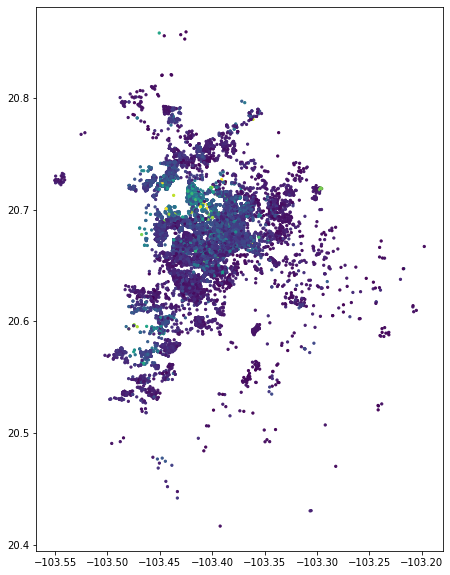

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot('Precio', markersize=5, ax=ax)

## Hex-bins

In [ ]:
c = 'Guadalajara'
res = 9
points_by_hex = 2
folder = 'hexgrid'
table = f'hexgrid_{res}_city'

query = f"SELECT * FROM {folder}.{table} WHERE \"metropolis\" LIKE \'{c}\'"
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
hex_gdf = hex_gdf[[f'hex_id_{res}','geometry','metropolis']]
print(hex_gdf.shape)
hex_gdf.head(2)

## Total value ($)

### Complete dataset

#### House + Apartment

In [ ]:
point_hex = gpd.sjoin(gdf, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

In [ ]:
point_hex = point_hex[['Precio',f'hex_id_{res}']].copy()

In [ ]:
point_hex_group = point_hex.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'Precio_count':'count'}, inplace=True)
point_hex_group.head(5)

In [ ]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

##### Plot

In [ ]:
hex_price.plot('Precio_mean')

In [ ]:
hex_price.plot('Precio_std')

In [ ]:
hex_price.plot('count')

##### Upload

In [ ]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_TotalValue_AllListing', 'household_price', if_exists='replace')

#### House

In [14]:
gdf_house = gdf.loc[gdf.Inmueble=='Casa'].copy()
point_hex = gpd.sjoin(gdf_house, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(6691, 11)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,index_right,hex_id_8,metropolis
1,Casa,15000.0,Tlajomulco,BOSQUE REAL DE SANTA ANITA,-103.493673,20.567822,POINT (-103.49367 20.56782),2019,986,8849ab5a07fffff,Guadalajara
2,Casa,15000.0,Tlajomulco,BOSQUE REAL DE SANTA ANITA,-103.494346,20.566570,POINT (-103.49435 20.56657),2019,986,8849ab5a07fffff,Guadalajara


In [15]:
point_hex = point_hex[['Precio',f'hex_id_{res}']].copy()

In [16]:
point_hex_group = point_hex.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'Precio_count':'count'}, inplace=True)
point_hex_group.head(5)

,Precio_mean,Precio_median,Precio_std,count
hex_id_8,,,,
88498c865bfffff,21866.666667,25000.0,9722.482536,6
88498c909bfffff,5500.000000,5500.0,1414.213562,2
88498c909dfffff,18800.000000,18800.0,22910.259710,2
88498c90c9fffff,6100.000000,5750.0,2130.727575,4
88498c90d5fffff,12000.000000,12000.0,NaN,1


In [17]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(482, 7)


,hex_id_8,geometry,metropolis,Precio_mean,Precio_median,Precio_std,count
0,8849ab592bfffff,"POLYGON ((-103.39263 20.63833, -103.39716 20.6...",Guadalajara,8120.0,8000.0,4048.264374,10
1,88498c95dbfffff,"POLYGON ((-103.31071 20.73802, -103.31579 20.7...",Guadalajara,3500.0,3500.0,NaN,1


##### Plot

<AxesSubplot:>

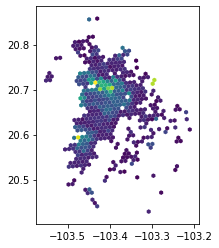

In [18]:
hex_price.plot('Precio_mean')

<AxesSubplot:>

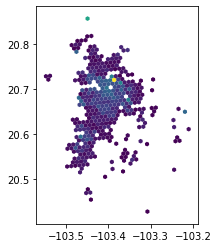

In [19]:
hex_price.plot('Precio_std')

<AxesSubplot:>

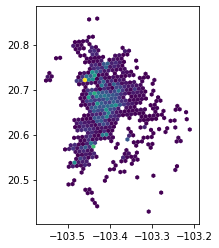

In [20]:
hex_price.plot('count')

##### Upload

In [21]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_TotalValue_House', 'household_price', if_exists='replace')

#### Apartment

In [22]:
gdf_app = gdf.loc[gdf.Inmueble=='Departamento'].copy()
point_hex = gpd.sjoin(gdf_app, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(11132, 11)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,index_right,hex_id_8,metropolis
0,Departamento,7000.0,Guadalajara,LAS TORRES,-103.379569,20.651848,POINT (-103.37957 20.65185),2019,670,88498c96c9fffff,Guadalajara
569,Departamento,9800.0,Guadalajara,JARDINES DE LA CRUZ,-103.381770,20.648202,POINT (-103.38177 20.64820),2019,670,88498c96c9fffff,Guadalajara


In [23]:
point_hex = point_hex[['Precio',f'hex_id_{res}']].copy()

In [24]:
point_hex_group = point_hex.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'Precio_count':'count'}, inplace=True)
point_hex_group.head(5)

,Precio_mean,Precio_median,Precio_std,count
hex_id_8,,,,
88498c865bfffff,9214.285714,9000.0,1349.603116,7
88498c90b1fffff,4600.000000,4600.0,NaN,1
88498c90dbfffff,5300.000000,5300.0,NaN,1
88498c9293fffff,4350.000000,4350.0,919.238816,2
88498c9405fffff,6800.000000,6800.0,NaN,1


In [25]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(364, 7)


,hex_id_8,geometry,metropolis,Precio_mean,Precio_median,Precio_std,count
0,8849ab592bfffff,"POLYGON ((-103.39263 20.63833, -103.39716 20.6...",Guadalajara,5900.000000,4600.0,3088.226491,8
1,88498c95dbfffff,"POLYGON ((-103.31071 20.73802, -103.31579 20.7...",Guadalajara,4266.666667,3450.0,1753.472745,6


##### Plot

<AxesSubplot:>

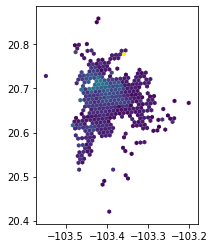

In [26]:
hex_price.plot('Precio_mean')

<AxesSubplot:>

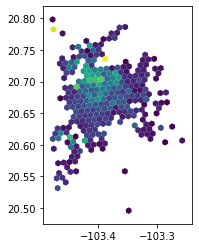

In [27]:
hex_price.plot('Precio_std')

<AxesSubplot:>

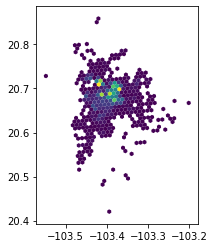

In [28]:
hex_price.plot('count')

##### Upload

In [29]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_TotalValue_Apartment', 'household_price', if_exists='replace')

### Sample dataset

#### House + Apartment

In [30]:
point_hex = gpd.sjoin(gdf, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(17823, 11)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,index_right,hex_id_8,metropolis
0,Departamento,7000.0,Guadalajara,LAS TORRES,-103.379569,20.651848,POINT (-103.37957 20.65185),2019,670,88498c96c9fffff,Guadalajara
569,Departamento,9800.0,Guadalajara,JARDINES DE LA CRUZ,-103.381770,20.648202,POINT (-103.38177 20.64820),2019,670,88498c96c9fffff,Guadalajara


In [31]:
point_count = point_hex.groupby(f'hex_id_{res}').count()
point_count = point_count.rename(columns={'Precio':'count'})

In [32]:
point_h_g_filter = point_count[point_count['count']>points_by_hex].copy()
point_h_g_filter = point_hex[point_hex[f'hex_id_{res}'].isin(list(point_h_g_filter.index))]

point_for_join = gpd.GeoDataFrame()

for hex_id in list(point_h_g_filter[f'hex_id_{res}'].unique()):
    
    gdf_tmp = point_h_g_filter.loc[point_h_g_filter[f'hex_id_{res}']==hex_id].sample(points_by_hex)
    
    point_for_join = pd.concat([point_for_join, gdf_tmp], ignore_index = True, axis = 0)
    
print(point_for_join.shape)

(1450, 11)


In [33]:
point_for_join = point_for_join[['Precio',f'hex_id_{res}']].copy()

point_hex_group = point_for_join.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'Precio_count':'count'}, inplace=True)
point_hex_group.head(5)

,Precio_mean,Precio_median,Precio_std,count
hex_id_8,,,,
88498c865bfffff,17840.0,13500.0,11876.573580,5
88498c940bfffff,8800.0,9000.0,4242.051391,5
88498c9411fffff,6200.0,6500.0,1805.547009,5
88498c9413fffff,9500.0,8500.0,2335.594143,5
88498c9415fffff,10400.0,9500.0,5164.784603,5


In [34]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(290, 7)


,hex_id_8,geometry,metropolis,Precio_mean,Precio_median,Precio_std,count
0,8849ab592bfffff,"POLYGON ((-103.39263 20.63833, -103.39716 20.6...",Guadalajara,6140.0,5000.0,3002.998501,5
1,88498c95dbfffff,"POLYGON ((-103.31071 20.73802, -103.31579 20.7...",Guadalajara,3920.0,3300.0,1715.225933,5


##### Plot

<AxesSubplot:>

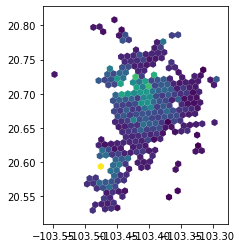

In [35]:
hex_price.plot('Precio_mean')

<AxesSubplot:>

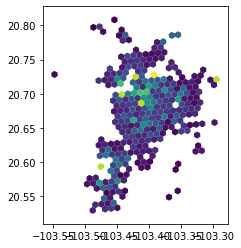

In [36]:
hex_price.plot('Precio_std')

<AxesSubplot:>

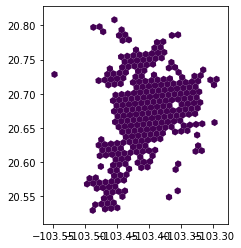

In [37]:
hex_price.plot('count')

##### Upload

In [38]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_TotalValue_AllListing_Sample', 'household_price', if_exists='replace')

#### House

In [39]:
gdf_house = gdf.loc[gdf.Inmueble=='Casa']
point_hex = gpd.sjoin(gdf_house, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(6691, 11)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,index_right,hex_id_8,metropolis
1,Casa,15000.0,Tlajomulco,BOSQUE REAL DE SANTA ANITA,-103.493673,20.567822,POINT (-103.49367 20.56782),2019,986,8849ab5a07fffff,Guadalajara
2,Casa,15000.0,Tlajomulco,BOSQUE REAL DE SANTA ANITA,-103.494346,20.566570,POINT (-103.49435 20.56657),2019,986,8849ab5a07fffff,Guadalajara


In [40]:
point_count = point_hex.groupby(f'hex_id_{res}').count()
point_count = point_count.rename(columns={'Precio':'count'})

In [41]:
point_h_g_filter = point_count[point_count['count']>points_by_hex].copy()
point_h_g_filter = point_hex[point_hex[f'hex_id_{res}'].isin(list(point_h_g_filter.index))]

point_for_join = gpd.GeoDataFrame()

for hex_id in list(point_h_g_filter[f'hex_id_{res}'].unique()):
    
    gdf_tmp = point_h_g_filter.loc[point_h_g_filter[f'hex_id_{res}']==hex_id].sample(points_by_hex)
    
    point_for_join = pd.concat([point_for_join, gdf_tmp], ignore_index = True, axis = 0)
    
print(point_for_join.shape)

(1165, 11)


In [42]:
point_for_join = point_for_join[['Precio',f'hex_id_{res}']].copy()

point_hex_group = point_for_join.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'Precio_count':'count'}, inplace=True)
point_hex_group.head(5)

,Precio_mean,Precio_median,Precio_std,count
hex_id_8,,,,
88498c865bfffff,19240.0,25000.0,8149.417157,5
88498c9411fffff,12060.0,12000.0,1190.798052,5
88498c9413fffff,9820.0,6200.0,5463.698381,5
88498c9419fffff,9300.0,9500.0,2361.143791,5
88498c941bfffff,12580.0,12000.0,5216.032975,5


In [43]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(233, 7)


,hex_id_8,geometry,metropolis,Precio_mean,Precio_median,Precio_std,count
0,8849ab592bfffff,"POLYGON ((-103.39263 20.63833, -103.39716 20.6...",Guadalajara,7640.0,7000.0,3220.714207,5
1,88498c96e3fffff,"POLYGON ((-103.36195 20.67014, -103.35741 20.6...",Guadalajara,29600.0,28000.0,8384.509527,5


##### Plot

<AxesSubplot:>

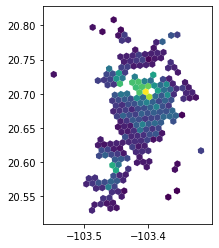

In [44]:
hex_price.plot('Precio_mean')

<AxesSubplot:>

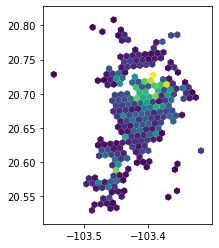

In [45]:
hex_price.plot('Precio_std')

<AxesSubplot:>

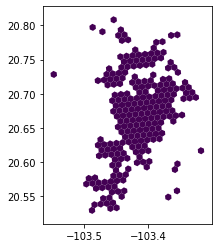

In [46]:
hex_price.plot('count')

##### Upload

In [47]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_TotalValue_House_Sample', 'household_price', if_exists='replace')

#### Apartment

In [48]:
gdf_apartment = gdf.loc[gdf.Inmueble=='Departamento']
point_hex = gpd.sjoin(gdf_apartment, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(11132, 11)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,index_right,hex_id_8,metropolis
0,Departamento,7000.0,Guadalajara,LAS TORRES,-103.379569,20.651848,POINT (-103.37957 20.65185),2019,670,88498c96c9fffff,Guadalajara
569,Departamento,9800.0,Guadalajara,JARDINES DE LA CRUZ,-103.381770,20.648202,POINT (-103.38177 20.64820),2019,670,88498c96c9fffff,Guadalajara


In [49]:
point_count = point_hex.groupby(f'hex_id_{res}').count()
point_count = point_count.rename(columns={'Precio':'count'})

In [50]:
point_h_g_filter = point_count[point_count['count']>points_by_hex].copy()
point_h_g_filter = point_hex[point_hex[f'hex_id_{res}'].isin(list(point_h_g_filter.index))]

point_for_join = gpd.GeoDataFrame()

for hex_id in list(point_h_g_filter[f'hex_id_{res}'].unique()):
    
    gdf_tmp = point_h_g_filter.loc[point_h_g_filter[f'hex_id_{res}']==hex_id].sample(points_by_hex)
    
    point_for_join = pd.concat([point_for_join, gdf_tmp], ignore_index = True, axis = 0)
    
print(point_for_join.shape)

(845, 11)


In [51]:
point_for_join = point_for_join[['Precio',f'hex_id_{res}']].copy()

point_hex_group = point_for_join.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'Precio_count':'count'}, inplace=True)
point_hex_group.head(5)

,Precio_mean,Precio_median,Precio_std,count
hex_id_8,,,,
88498c865bfffff,9500.0,10000.0,1500.000000,5
88498c9411fffff,12600.0,9500.0,8734.987121,5
88498c9413fffff,7320.0,7000.0,535.723809,5
88498c9417fffff,9380.0,9900.0,2376.341726,5
88498c9419fffff,6860.0,7500.0,2592.874852,5


In [52]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(169, 7)


,hex_id_8,geometry,metropolis,Precio_mean,Precio_median,Precio_std,count
0,8849ab592bfffff,"POLYGON ((-103.39263 20.63833, -103.39716 20.6...",Guadalajara,6600.0,4600.0,3876.854395,5
1,88498c95dbfffff,"POLYGON ((-103.31071 20.73802, -103.31579 20.7...",Guadalajara,4460.0,3600.0,1887.591057,5


##### Plot

<AxesSubplot:>

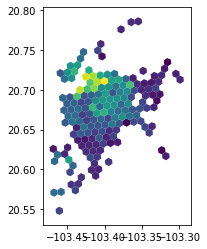

In [53]:
hex_price.plot('Precio_mean')

<AxesSubplot:>

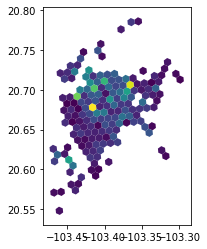

In [54]:
hex_price.plot('Precio_std')

<AxesSubplot:>

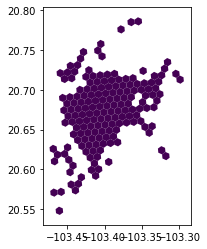

In [55]:
hex_price.plot('count')

##### Upload

In [56]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_TotalValue_Apartment_Sample', 'household_price', if_exists='replace')

## $ / m²

In [57]:
idx = gdf['Metros cuadrados de construcción'].isna()
gdf_sq = gdf[~idx].copy()
gdf_sq = gdf_sq.loc[gdf['Metros cuadrados de construcción']>0].copy()
print(gdf_sq.shape)

(33262, 10)


In [58]:
gdf_sq['$_sq_m'] = gdf_sq['Precio'] / gdf_sq['Metros cuadrados de construcción']

#### Remove outliers

In [59]:
from scipy import stats

z = np.abs(stats.zscore(gdf_sq['$_sq_m']))

gdf_sq = gdf_sq[z < 3].copy()

gdf_sq.shape

(33247, 11)

### Complete dataset

#### House + Apartment

In [60]:
point_hex = gpd.sjoin(gdf_sq, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(33247, 14)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,Metros cuadrados de terreno,Metros cuadrados de construcción,$_sq_m,index_right,hex_id_9,metropolis
9297,Casa,470234.0,GUADALAJARA,PARQUES DEL NILO I,-103.287175,20.649130,POINT (-103.28718 20.64913),2020,75.0,95.0,4949.831579,1651,89498c97157ffff,Guadalajara
59791,Casa,1083507.0,GUADALAJARA,PARQUES DEL NILO 2a SECCION,-103.284773,20.649317,POINT (-103.28477 20.64932),2021,120.0,160.0,6771.918750,1651,89498c97157ffff,Guadalajara


In [61]:
point_hex = point_hex[['$_sq_m',f'hex_id_{res}']].copy()

In [62]:
point_hex_group = point_hex.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'$_sq_m_count':'count'}, inplace=True)
point_hex_group.head(5)

,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
hex_id_9,,,,
89498c86483ffff,29767.441860,29767.441860,NaN,1
89498c86487ffff,22241.086557,22648.648649,2997.134682,4
89498c86493ffff,7789.473684,7789.473684,NaN,1
89498c86497ffff,19764.150943,19764.150943,NaN,1
89498c86597ffff,11736.302011,11736.302011,NaN,1


In [63]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(3296, 7)


,hex_id_9,geometry,metropolis,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
0,89498c9710bffff,"POLYGON ((-103.28985 20.65044, -103.28775 20.6...",Guadalajara,14081.133795,12068.965517,6403.156983,7
1,89498c94e73ffff,"POLYGON ((-103.32643 20.72902, -103.32433 20.7...",Guadalajara,13929.764211,12507.215007,4049.142912,6


##### Plot

<AxesSubplot:>

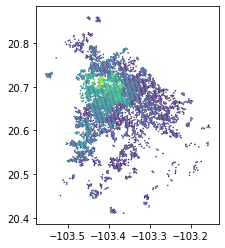

In [64]:
hex_price.plot('$_sq_m_mean')

<AxesSubplot:>

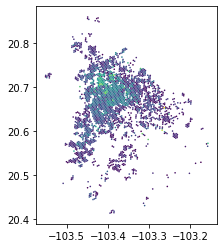

In [65]:
hex_price.plot('$_sq_m_std')

<AxesSubplot:>

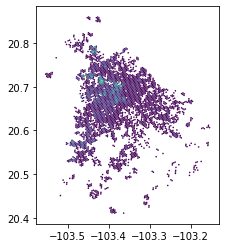

In [66]:
hex_price.plot('count')

##### Upload

In [67]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_$_sq_m_AllListing', 'household_price', if_exists='replace')

#### House

In [68]:
gdf_sq_house = gdf_sq.loc[gdf_sq.Inmueble=='Casa']
point_hex = gpd.sjoin(gdf_sq_house, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(22292, 14)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,Metros cuadrados de terreno,Metros cuadrados de construcción,$_sq_m,index_right,hex_id_9,metropolis
9297,Casa,470234.0,GUADALAJARA,PARQUES DEL NILO I,-103.287175,20.649130,POINT (-103.28718 20.64913),2020,75.0,95.0,4949.831579,1651,89498c97157ffff,Guadalajara
59791,Casa,1083507.0,GUADALAJARA,PARQUES DEL NILO 2a SECCION,-103.284773,20.649317,POINT (-103.28477 20.64932),2021,120.0,160.0,6771.918750,1651,89498c97157ffff,Guadalajara


In [69]:
point_hex = point_hex[['$_sq_m',f'hex_id_{res}']].copy()

In [70]:
point_hex_group = point_hex.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'$_sq_m_count':'count'}, inplace=True)
point_hex_group.head(5)

,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
hex_id_9,,,,
89498c86483ffff,29767.441860,29767.441860,NaN,1
89498c86487ffff,22241.086557,22648.648649,2997.134682,4
89498c86493ffff,7789.473684,7789.473684,NaN,1
89498c86497ffff,19764.150943,19764.150943,NaN,1
89498c86597ffff,11736.302011,11736.302011,NaN,1


In [71]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(3172, 7)


,hex_id_9,geometry,metropolis,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
0,89498c9710bffff,"POLYGON ((-103.28985 20.65044, -103.28775 20.6...",Guadalajara,8272.698413,7738.095238,1819.876484,3
1,89498c94e73ffff,"POLYGON ((-103.32643 20.72902, -103.32433 20.7...",Guadalajara,11490.740741,11250.000000,645.696421,3


##### Plot

<AxesSubplot:>

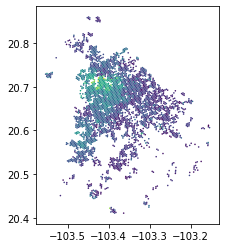

In [72]:
hex_price.plot('$_sq_m_mean')

<AxesSubplot:>

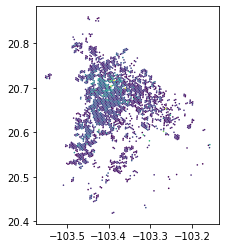

In [73]:
hex_price.plot('$_sq_m_std')

<AxesSubplot:>

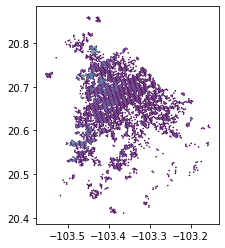

In [74]:
hex_price.plot('count')

##### Upload

In [75]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_$_sq_m_House', 'household_price', if_exists='replace')

#### Apartment

In [76]:
gdf_sq_apartment = gdf_sq.loc[gdf_sq.Inmueble=='Departamento']
point_hex = gpd.sjoin(gdf_sq_apartment, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(10955, 14)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,Metros cuadrados de terreno,Metros cuadrados de construcción,$_sq_m,index_right,hex_id_9,metropolis
9497,Departamento,1690000.0,ZAPOPAN,LOMAS DE LA VICTORIA,-103.400169,20.634396,POINT (-103.40017 20.63440),2020,105.0,100.0,16900.000000,22655,8949ab5906fffff,Guadalajara
52644,Departamento,3421000.0,ZAPOPAN,LOMA BONITA SUR,-103.401786,20.635679,POINT (-103.40179 20.63568),2021,90.0,90.0,38011.111111,22655,8949ab5906fffff,Guadalajara


In [77]:
point_hex = point_hex[['$_sq_m',f'hex_id_{res}']].copy()

In [78]:
point_hex_group = point_hex.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'$_sq_m_count':'count'}, inplace=True)
point_hex_group.head(5)

,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
hex_id_9,,,,
89498c903d7ffff,15691.489362,15691.489362,NaN,1
89498c90977ffff,2899.779167,2899.779167,NaN,1
89498c90b03ffff,7017.075000,7017.075000,NaN,1
89498c90d23ffff,11052.631579,11052.631579,NaN,1
89498c90d6bffff,10727.272727,10727.272727,NaN,1


In [79]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(1290, 7)


,hex_id_9,geometry,metropolis,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
0,89498c9710bffff,"POLYGON ((-103.28985 20.65044, -103.28775 20.6...",Guadalajara,18437.460331,19409.974328,4555.382418,4
1,89498c94e73ffff,"POLYGON ((-103.32643 20.72902, -103.32433 20.7...",Guadalajara,16368.787681,14533.333333,4767.123396,3


##### Plot

<AxesSubplot:>

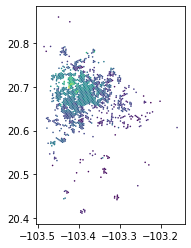

In [80]:
hex_price.plot('$_sq_m_mean')

<AxesSubplot:>

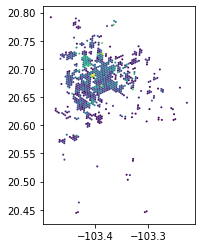

In [81]:
hex_price.plot('$_sq_m_std')

<AxesSubplot:>

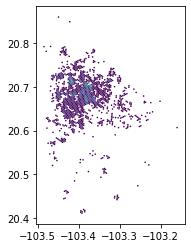

In [82]:
hex_price.plot('count')

##### Upload

In [83]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_$_sq_m_Apartment', 'household_price', if_exists='replace')

### Sample dataset

#### House + Apartment

In [84]:
point_hex = gpd.sjoin(gdf_sq, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(33247, 14)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,Metros cuadrados de terreno,Metros cuadrados de construcción,$_sq_m,index_right,hex_id_9,metropolis
9297,Casa,470234.0,GUADALAJARA,PARQUES DEL NILO I,-103.287175,20.649130,POINT (-103.28718 20.64913),2020,75.0,95.0,4949.831579,1651,89498c97157ffff,Guadalajara
59791,Casa,1083507.0,GUADALAJARA,PARQUES DEL NILO 2a SECCION,-103.284773,20.649317,POINT (-103.28477 20.64932),2021,120.0,160.0,6771.918750,1651,89498c97157ffff,Guadalajara


In [85]:
point_count = point_hex.groupby(f'hex_id_{res}').count()
point_count = point_count.rename(columns={'Precio':'count'})

In [86]:
point_h_g_filter = point_count[point_count['count']>points_by_hex].copy()
point_h_g_filter = point_hex[point_hex[f'hex_id_{res}'].isin(list(point_h_g_filter.index))]

point_for_join = gpd.GeoDataFrame()

for hex_id in list(point_h_g_filter[f'hex_id_{res}'].unique()):
    
    gdf_tmp = point_h_g_filter.loc[point_h_g_filter[f'hex_id_{res}']==hex_id].sample(points_by_hex)
    
    point_for_join = pd.concat([point_for_join, gdf_tmp], ignore_index = True, axis = 0)
    
print(point_for_join.shape)

(4120, 14)


In [87]:
point_for_join = point_for_join[['$_sq_m',f'hex_id_{res}']].copy()

point_hex_group = point_for_join.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'$_sq_m_count':'count'}, inplace=True)
point_hex_group.head(5)

,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
hex_id_9,,,,
89498c86487ffff,21833.524465,21833.524465,5126.794464,2
89498c865a3ffff,30006.410256,30006.410256,13425.963371,2
89498c865a7ffff,24806.034483,24806.034483,1493.458288,2
89498c865b7ffff,28750.000000,28750.000000,15202.795796,2
89498c9015bffff,10237.957825,10237.957825,2865.469789,2


In [88]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(2060, 7)


,hex_id_9,geometry,metropolis,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
0,89498c9710bffff,"POLYGON ((-103.28985 20.65044, -103.28775 20.6...",Guadalajara,9903.530378,9903.530378,3062.387743,2
1,89498c94e73ffff,"POLYGON ((-103.32643 20.72902, -103.32433 20.7...",Guadalajara,11125.000000,11125.000000,176.776695,2


##### Plot

<AxesSubplot:>

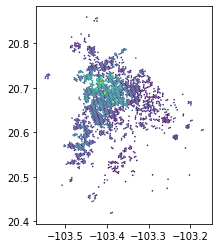

In [89]:
hex_price.plot('$_sq_m_mean')

<AxesSubplot:>

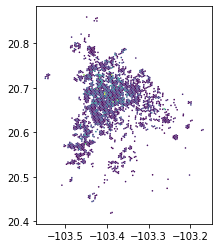

In [90]:
hex_price.plot('$_sq_m_std')

<AxesSubplot:>

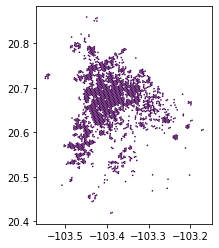

In [91]:
hex_price.plot('count')

##### Upload

In [92]:
aup.gdf_to_db_slow(hex_price,f'AMG_{tipo}_HexRes{res}_$_sq_m_AllListing_Sample', 'household_price', if_exists='replace')

#### House

In [93]:
gdf_sq_house = gdf_sq.loc[gdf_sq.Inmueble=='Casa']
point_hex = gpd.sjoin(gdf_sq_house, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(22292, 14)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,Metros cuadrados de terreno,Metros cuadrados de construcción,$_sq_m,index_right,hex_id_9,metropolis
9297,Casa,470234.0,GUADALAJARA,PARQUES DEL NILO I,-103.287175,20.649130,POINT (-103.28718 20.64913),2020,75.0,95.0,4949.831579,1651,89498c97157ffff,Guadalajara
59791,Casa,1083507.0,GUADALAJARA,PARQUES DEL NILO 2a SECCION,-103.284773,20.649317,POINT (-103.28477 20.64932),2021,120.0,160.0,6771.918750,1651,89498c97157ffff,Guadalajara


In [94]:
point_count = point_hex.groupby(f'hex_id_{res}').count()
point_count = point_count.rename(columns={'Precio':'count'})

In [95]:
point_h_g_filter = point_count[point_count['count']>points_by_hex].copy()
point_h_g_filter = point_hex[point_hex[f'hex_id_{res}'].isin(list(point_h_g_filter.index))]

point_for_join = gpd.GeoDataFrame()

for hex_id in list(point_h_g_filter[f'hex_id_{res}'].unique()):
    
    gdf_tmp = point_h_g_filter.loc[point_h_g_filter[f'hex_id_{res}']==hex_id].sample(points_by_hex)
    
    point_for_join = pd.concat([point_for_join, gdf_tmp], ignore_index = True, axis = 0)
    
print(point_for_join.shape)

(3726, 14)


In [96]:
point_for_join = point_for_join[['$_sq_m',f'hex_id_{res}']].copy()

point_hex_group = point_for_join.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'$_sq_m_count':'count'}, inplace=True)
point_hex_group.head(5)

,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
hex_id_9,,,,
89498c86487ffff,21833.524465,21833.524465,5126.794464,2
89498c865a3ffff,25896.990741,25896.990741,941.172220,2
89498c865a7ffff,25241.760545,25241.760545,4132.156410,2
89498c865b7ffff,22579.030558,22579.030558,160.198059,2
89498c9015bffff,10237.957825,10237.957825,2865.469789,2


In [97]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(1863, 7)


,hex_id_9,geometry,metropolis,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
0,89498c9710bffff,"POLYGON ((-103.28985 20.65044, -103.28775 20.6...",Guadalajara,8540.000000,8540.000000,2489.015870,2
1,89498c94e73ffff,"POLYGON ((-103.32643 20.72902, -103.32433 20.7...",Guadalajara,11736.111111,11736.111111,687.464926,2


##### Plot

<AxesSubplot:>

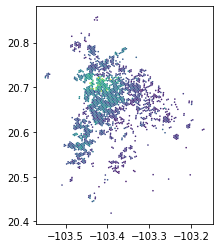

In [98]:
hex_price.plot('$_sq_m_mean')

<AxesSubplot:>

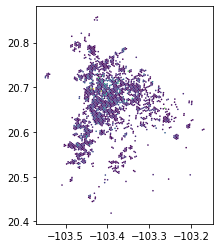

In [99]:
hex_price.plot('$_sq_m_std')

<AxesSubplot:>

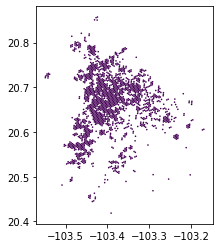

In [100]:
hex_price.plot('count')

##### Upload

In [101]:
aup.gdf_to_db_slow(hex_price, f'AMG_{tipo}_HexRes{res}_$_sq_m_House_Sample', 'household_price', if_exists='replace')

#### Apartment

In [102]:
gdf_sq_apartment = gdf_sq.loc[gdf_sq.Inmueble=='Departamento']
point_hex = gpd.sjoin(gdf_sq_apartment, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(10955, 14)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,Metros cuadrados de terreno,Metros cuadrados de construcción,$_sq_m,index_right,hex_id_9,metropolis
9497,Departamento,1690000.0,ZAPOPAN,LOMAS DE LA VICTORIA,-103.400169,20.634396,POINT (-103.40017 20.63440),2020,105.0,100.0,16900.000000,22655,8949ab5906fffff,Guadalajara
52644,Departamento,3421000.0,ZAPOPAN,LOMA BONITA SUR,-103.401786,20.635679,POINT (-103.40179 20.63568),2021,90.0,90.0,38011.111111,22655,8949ab5906fffff,Guadalajara


In [103]:
point_count = point_hex.groupby(f'hex_id_{res}').count()
point_count = point_count.rename(columns={'Precio':'count'})

In [104]:
point_h_g_filter = point_count[point_count['count']>points_by_hex].copy()
point_h_g_filter = point_hex[point_hex[f'hex_id_{res}'].isin(list(point_h_g_filter.index))]

point_for_join = gpd.GeoDataFrame()

for hex_id in list(point_h_g_filter[f'hex_id_{res}'].unique()):
    
    gdf_tmp = point_h_g_filter.loc[point_h_g_filter[f'hex_id_{res}']==hex_id].sample(points_by_hex)
    
    point_for_join = pd.concat([point_for_join, gdf_tmp], ignore_index = True, axis = 0)
    
print(point_for_join.shape)

(1388, 14)


In [105]:
point_for_join = point_for_join[['$_sq_m',f'hex_id_{res}']].copy()

point_hex_group = point_for_join.groupby(f'hex_id_{res}').agg(['mean','median','std',
                                                        'count'])
point_hex_group.columns = point_hex_group.columns.map('_'.join).str.strip('_')
point_hex_group.rename(columns={'$_sq_m_count':'count'}, inplace=True)
point_hex_group.head(5)

,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
hex_id_9,,,,
89498c9296fffff,15719.181198,15719.181198,1839.411113,2
89498c940b7ffff,23230.769231,23230.769231,3916.283711,2
89498c9412bffff,14615.384615,14615.384615,0.000000,2
89498c94137ffff,27739.390349,27739.390349,22481.715224,2
89498c94163ffff,9166.666667,9166.666667,2085.058457,2


In [106]:
hex_price = pd.merge(hex_gdf, point_hex_group.reset_index(), on=f'hex_id_{res}')
print(hex_price.shape)
hex_price.head(2)

(694, 7)


,hex_id_9,geometry,metropolis,$_sq_m_mean,$_sq_m_median,$_sq_m_std,count
0,89498c9710bffff,"POLYGON ((-103.28985 20.65044, -103.28775 20.6...",Guadalajara,21307.996044,21307.996044,2196.176235,2
1,89498c94e73ffff,"POLYGON ((-103.32643 20.72902, -103.32433 20.7...",Guadalajara,13662.770563,13662.770563,1231.161677,2


##### Plot

<AxesSubplot:>

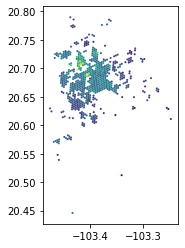

In [107]:
hex_price.plot('$_sq_m_mean')

<AxesSubplot:>

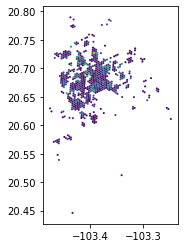

In [108]:
hex_price.plot('$_sq_m_std')

<AxesSubplot:>

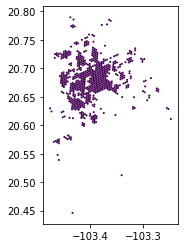

In [109]:
hex_price.plot('count')

##### Upload

In [110]:
aup.gdf_to_db_slow(hex_price, f'AMG_{tipo}_HexRes{res}_$_sq_m_Apartment_Sample', 'household_price', if_exists='replace')